# ALNS

## Repair

In [1]:
class RepairOperators:
    def __init__(self, solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance
        self.insertion_log = []  # record

    #*****************************************************************************************************
    #Start of greedy insertion
    def greedy_insertion(self, removed_pairs):
        # loop the removed pairs
        for pickup, delivery in removed_pairs:
            best_cost = float('inf')
            best_route = None
            best_insert_position = None
            # loop each route to find a suitable location to insert 
            temp_solution = deepcopy(self.solution)
            for vehicle_id, route in enumerate(self.solution.routes):
                for i in range(1, len(route)):
                    for j in range(i, len(route)):
                        temp_route = route[:i] + [pickup] + route[i:j] + [delivery] + route[j:]
                        # temp_solution = deepcopy(self.solution)
                        temp_solution.routes[vehicle_id] = temp_route
                        temp_solution.update_all()

                        if temp_solution.is_feasible():
                            cost = temp_solution.objective_function()
                            if cost < best_cost:
                                best_cost = cost
                                best_route = vehicle_id
                                best_insert_position = (i, j)
            
            # update the self.solution
            if best_route is not None and best_insert_position is not None:
                self.insert_single_request(pickup,delivery,best_route, best_insert_position)
        
        return self.solution
    #*****************************************************************************************************
    #End of greedy insertion

    #*****************************************************************************************************
    #Start of regret insertion
    def regret_insertion(self, removed_pairs, k):
        while removed_pairs:
            insertion_costs = []
            for pickup, delivery in removed_pairs: # iterate every pair
                costs = []
                for vehicle_id, route in enumerate(self.solution.routes): # iterate every route
                    min_cost = float('inf')
                    temp_solution = deepcopy(self.solution)
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [pickup] + route[i:j] + [delivery] + route[j:]
                            # temp_solution = deepcopy(self.solution)
                            temp_solution.routes[vehicle_id] = temp_route
                            temp_solution.update_all()

                            if temp_solution.is_feasible():
                                cost = temp_solution.objective_function()
                                if cost < min_cost:
                                    min_cost = cost
                                    best_i, best_j = i,j
                    
                    if min_cost < float('inf'):
                        costs.append((min_cost, vehicle_id, best_i, best_j))
                costs.sort(key=lambda x:x[0])
                insertion_costs.append((pickup, delivery, costs))

            
            best_request = None
            best_route = None
            best_insert_position = None
            for pickup, delivery, costs in insertion_costs:
                # 无法被插入到任何路径，直接跳过
                if len(costs) == 0:
                    removed_pairs.remove((pickup, delivery))
                    #print(f"Request ({pickup}, {delivery}) cannot be inserted into any route.")
                    continue
                # 处理插入机会少于k的请求
                elif len(costs) > 0 and len(costs) < k:
                    best_request =  (pickup, delivery)
                    best_route = costs[0][1]
                    best_insert_position = (costs[0][2], costs[0][3])
                    break
                # 如果没有插入机会少于k的请求，则选择最大遗憾值的请求
                elif  len(costs) >= k:
                    max_regret = float('-inf')
                    regret = sum(cost[0] for cost in costs[:k]) - costs[0][0]
                    if regret > max_regret:
                        max_regret = regret
                        best_request = (pickup, delivery)
                        best_route = costs[0][1]
                        best_insert_position = (costs[0][2], costs[0][3])   

            # 插入最佳请求
            if best_request is not None and best_route is not None and best_insert_position is not None:
                removed_pairs.remove(best_request)
                pickup, delivery = best_request
                self.insert_single_request(pickup, delivery, best_route, best_insert_position)
        
        return self.solution
        
    #*****************************************************************************************************
    #End of regret insertion
    def insert_single_request(self, pickup, delivery, vehicle_id, insert_position):
        i, j = insert_position
        self.solution.routes[vehicle_id] = self.solution.routes[vehicle_id][:i] \
                                           + [pickup] + self.solution.routes[vehicle_id][i:j] + [delivery] \
                                           + self.solution.routes[vehicle_id][j:]
        self.solution.update_all() # update all of the things
        self.record_insertion(vehicle_id, pickup, delivery, insert_position)  # 记录插入位置
    
    def record_insertion(self, vehicle_id, pickup, delivery, position):
        """
        记录插入位置
        vehicle_id: 车辆ID
        pickup: 取货点
        delivery: 送货点
        position: 插入位置 (i, j)
        """
        self.insertion_log.append({
        'vehicle_id': vehicle_id,
        'pickup': pickup,
        'delivery': delivery,
        'position': position
        })

    def get_insertion_log(self):
        """
        获取插入日志
        :return: 插入日志
        """
        return self.insertion_log

## Removal

In [2]:
class RemovalOperators:
    '''
    1.shaw removal
    -  calculate_similarity
    -  get_arrival_time
    2.random removal
    3.worst removal
    - calculate_contribution
    4.remove_requests
    '''
    def __init__(self, solution):
        self.solution = solution
        self.instance = solution.instance 

    #Start of SISR removal
    # Main SISR removal function
    def SISR_removal(self, L_max, avg_remove_order, d_matrix):
        remaining_orders = self.solution.unvisited_requests
        routes_copy = deepcopy(self.solution.routes)
        n_orders = self.instance.n
        removed_list = []
        deconstructed_route_list = []
        k_s, l_s_max = self.number_of_strings(L_max, avg_remove_order, routes_copy, n_orders)
        k_s = min(k_s, len(routes_copy))
        for i in range(int(k_s)):
            if i == 0:
                start_order = int(self.order_to_start(n_orders, remaining_orders))
                # while any(start_order in sublist for sublist in routes_copy) is False:
                #     start_order = int(self.order_to_start(n_orders))
                route = self.find_lists_containing_element(routes_copy, start_order)
                l_t = self.number_of_orders(l_s_max, route)
                routes_copy, removed_list, deconstructed_route_list, primal_sorted_indices = self.primal_string_removal(
                    d_matrix, routes_copy, route, l_t, start_order, n_orders, removed_list, deconstructed_route_list)
            elif primal_sorted_indices == []:
                break
            else:
                route, next_order = self.find_next_list(primal_sorted_indices, routes_copy, remaining_orders)
                if route == []:
                    break
                l_t = self.number_of_orders(l_s_max, route)
                routes_copy, removed_list, deconstructed_route_list, primal_sorted_indices = self.other_string_removal(
                    d_matrix, routes_copy, route, l_t, next_order, n_orders, removed_list, deconstructed_route_list,
                    primal_sorted_indices)

        remaining_routes = deconstructed_route_list + routes_copy
        removed_list = removed_list  # + remaining_orders

        return self.remove_requests(removed_list)

    def number_of_strings(self, L_max, avg_remove_order, routes, n_orders):
        T_avg = np.floor(n_orders / len(routes))
        l_s_max = min(T_avg, L_max)
        k_s_max = 4 * avg_remove_order / (1 + l_s_max) - 1
        k_s = np.floor(np.random.uniform(1, k_s_max + 1))

        return k_s, l_s_max

    # Generate number of orders to remove in each string
    def number_of_orders(self, l_s_max, route):
        l_t_max = min(l_s_max, (len(route) - 2) / 2)
        l_t = np.floor(np.random.uniform(1, l_t_max + 1))

        return l_t

    # Generate random order to start, remove orders according to order distance matrix
    def order_to_start(self, n_orders, remaining_order):
        reference_order = np.floor(np.random.uniform(1, n_orders + 1))
        # if remaining_order != None:
        while reference_order in remaining_order:
            reference_order = np.floor(np.random.uniform(1, n_orders + 1))
        return reference_order

    def find_lists_containing_element(self, routes, order):
        return [route for route in routes if order in route][0]

    def primal_string_removal(self, d_matrix, routes, route, l_t, reference_order, n_orders, removed_list,
                              deconstructed_route_list):
        distances = d_matrix[reference_order - 1]
        sorted_indices = np.argsort(distances).tolist()
        # print('sorted_indices',sorted_indices)
        # sorted_indices_updated = sorted_indices.copy()
        route_1 = deepcopy(route)
        a = 0
        for i in sorted_indices:
            if a <= l_t - 1:
                if i + 1 in route:
                    route_1.remove(i + 1)
                    removed_list.append(i + 1)
                    route_1.remove(i + 1 + n_orders)
                    removed_list.append(i + 1 + n_orders)
                a += 1
            else:
                break
        for order in route[1:-1]:
            if order > n_orders:
                continue
            else:
                sorted_indices.remove(order - 1)
        routes.remove(route)

        deconstructed_route_list.append(route_1)
        # print('deconstructed_route_list',deconstructed_route_list)

        return routes, removed_list, deconstructed_route_list, sorted_indices

    def find_next_list(self, primal_sorted_indices, routes, remaining_order):
        d = 0
        # print('routes:',routes)
        # print('primal_sorted_indices',primal_sorted_indices)
        i = primal_sorted_indices[d]
        next_order = i + 1
        # print('next_order',next_order)
        # if remaining_order != None:
        while (next_order in remaining_order) and d < len(remaining_order)-1:
            print(primal_sorted_indices)
            d = d + 1
            i = primal_sorted_indices[d]
            next_order = i + 1
        # while any(next_order in sublist for sublist in routes) is False:
        #             next_order = i + 1
        if d == len(remaining_order) - 1 and len(remaining_order) > 0:
            return [], None
        else:
            return [route for route in routes if next_order in route][0], next_order

    def other_string_removal(self, d_matrix, routes, route, l_t, reference_order, n_orders, removed_list,
                             deconstructed_route_list, primal_sorted_indices):
        distances = d_matrix[reference_order - 1]
        sorted_indices = np.argsort(distances).tolist()
        route_1 = deepcopy(route)
        a = 0
        for i in sorted_indices:
            if a <= l_t - 1:
                if i + 1 in route:
                    route_1.remove(i + 1)
                    removed_list.append(i + 1)
                    route_1.remove(i + 1 + n_orders)
                    removed_list.append(i + 1 + n_orders)
                a += 1
            else:
                break
        # route_2 = deepcopy(route)
        for order in route[1:-1]:
            if order > n_orders:
                continue
            else:
                primal_sorted_indices.remove(order - 1)
        routes.remove(route)

        deconstructed_route_list.append(route_1)

        return routes, removed_list, deconstructed_route_list, primal_sorted_indices
    # *****************************************************************************************
    # End of SISR removal

    #*****************************************************************************************************
    #Start of shaw removal
    def shaw_removal(self, num_remove, p):
        removed_requests = []
        remaining_requests = list(self.solution.visited_requests)

        # Select a request randomly
        initial_request = random.choice(remaining_requests)
        removed_requests.append(initial_request)
        remaining_requests.remove(initial_request)

        # Normalization factor
        max_distance = np.max(self.instance.distance_matrix)
        max_arrive_time = np.max([np.max(arrival_time) for arrival_time in self.solution.route_arrival_times])

        while len(removed_requests) < num_remove:
            last_removed = random.choice(removed_requests)
            L = [req for req in remaining_requests]
            L.sort(key = lambda req: self.calculate_similarity(last_removed, req, max_distance,max_arrive_time))

            y = random.random()
            selected_request = L[int(y**p*len(L))]
            removed_requests.append(selected_request)
            remaining_requests.remove(selected_request)
        
        return self.remove_requests(removed_requests)
    
    def calculate_similarity(self,req1,req2,max_distance,max_arrive_time):
        '''for shaw_removal'''
        pickup1, delivery1 = req1, req1 + self.instance.n
        pickup2, delivery2 = req2, req2 + self.instance.n

        dist_pickup = self.instance.distance_matrix[pickup1][pickup2] / max_distance
        dist_delivery = self.instance.distance_matrix[delivery1][delivery2] / max_distance

        arrival_time_pickup = (self.get_arrival_time(pickup1) - self.get_arrival_time(pickup2))/ max_arrive_time
        arrival_time_delivery = (self.get_arrival_time(delivery1) - self.get_arrival_time(delivery2)) / max_arrive_time

        return  dist_pickup + dist_delivery + arrival_time_pickup +  arrival_time_delivery
    
    def get_arrival_time(self, node):
        '''
        for shaw_removal
        get the arrival time of the node
        '''
        for vehicle_id, route in enumerate(self.solution.routes):
            if node in route:
                return self.solution.route_arrival_times[vehicle_id][route.index(node)]
        raise NodeNotFoundError(node)
    #*****************************************************************************************************
    #End of shaw removal
    
    #*****************************************************************************************************
    #Start of random removal
    def random_removal(self, num_remove):
        remaining_requests = list(self.solution.visited_requests)
        removed_requests = random.sample(remaining_requests, num_remove)
        return self.remove_requests(removed_requests)
    #*****************************************************************************************************
    #End of random removal
    
    #*****************************************************************************************************
    #Start of worst removal
    def worst_removal(self, num_remove):
        remaining_requests = list(self.solution.visited_requests)
        contributions = [(req, self.calculate_contribution(req)) for req in remaining_requests]
        contributions.sort(key=lambda x: x[1], reverse=True)
        removed_requests = [req for req, _ in contributions[:num_remove]]
        #print(contributions)
        return self.remove_requests(removed_requests)

    def calculate_contribution(self, req):
        '''for  worst_removal'''
        temp_solution = deepcopy(self.solution)
        pickup, delivery = req, req + self.instance.n

        # remove the pickup and delivery points
        for route in temp_solution.routes:
            if pickup in route:
                route.remove(pickup)
                route.remove(delivery)

        # update
        temp_solution.update_all()
        original_objective = self.solution.objective_function()
        new_objective = temp_solution.objective_function()

        # calculate the contribution
        contribution = original_objective - new_objective
        return contribution
        #*****************************************************************************************************
        #End of worst removal

    def remove_requests(self, requests):
        new_solution = deepcopy(self.solution)
        #removed_pairs = []
        
        for request in requests:
            pickup_node, delivery_node = request, request + self.instance.n
            for route in new_solution.routes:
                if pickup_node in route:
                    route.remove(pickup_node)
                    route.remove(delivery_node)

            #removed_pairs.append((pickup_node, delivery_node))
            new_solution.update_all() # update all of the things
        
        #return new_solution, removed_pairs
        return new_solution

## ALNS

In [74]:
from solution import PDPTWSolution
import random 
import numpy as np
from copy import deepcopy
from collections import defaultdict
import time

class ALNS:
    def __init__(self, initial_solution, 
                 params_operators, d_matrix, dist_matrix, battery,
                 max_no_improve, segment_length, num_segments, r, sigma,
                 start_temp, cooling_rate):

        # Solution
        self.current_solution = deepcopy(initial_solution) 
        self.best_solution = deepcopy(initial_solution)
        self.charging_solution = deepcopy(initial_solution)
        self.charging_solution.battery_capacity = battery*2/self.current_solution.instance.speed*60

        self.best_charging_route = []

        # Parameters for Operators
        self.num_removal = params_operators['num_removal']
        self.p = params_operators['p']
        self.k = params_operators['k']
        self.L_max = params_operators['L_max']
        self.avg_remove_order = params_operators['avg_remove_order']

        self.d_matrix = d_matrix
        self.dist_matrix = dist_matrix
        self.battery = battery

        # Parameters for ALNS
        self.max_no_improve = max_no_improve   
        self.segment_length = segment_length
        self.num_segments = num_segments
        #self.max_iterations = segment_length * num_segments
        self.r = r
        self.sigma1 = sigma[0]
        self.sigma2 = sigma[1] 
        self.sigma3 = sigma[2]

        # Acceptance criteria
        self.start_temp = start_temp 
        self.cooling_rate = cooling_rate  
        self.current_temp = start_temp 

        # ======== Initialization============
        # Methods list
        # self.removal_list = [0, 1, 2, 3]
        self.removal_list = [0, 2, 3]
        self.repair_list = [0, 1]
        
        # Weights
        self.removal_weights = np.zeros((num_segments, len(self.removal_list)))
        self.repair_weights = np.zeros((num_segments, len(self.repair_list)))
        self.removal_weights[0] = np.ones(len(self.removal_list)) / len(self.removal_list)
        self.repair_weights[0] = np.ones(len(self.repair_list)) / len(self.repair_list)

        # Scores
        self.removal_scores = np.zeros((num_segments, len(self.removal_list)))
        self.repair_scores = np.zeros((num_segments, len(self.repair_list)))

        # Theta: the number of times we have attempted to use heuristic i in every segment
        self.removal_theta = np.zeros((num_segments, len(self.removal_list)))
        self.repair_theta = np.zeros((num_segments, len(self.repair_list)))

    def select_operator(self, weights):
        '''
        Select the heuristic algorithms using roulette wheel selection principle
        The insertion heuristic is selected independently of the removal heuristic

        :param weights: weight lists for different operators
        :return: index for the selected operator
        '''
        total_weight = np.sum(weights)
        probabilities = weights / total_weight
        cumulative_probabilities = np.cumsum(probabilities)
        random_number = random.random()
        for i, probability in enumerate(cumulative_probabilities):
            if random_number < probability:
                return i
        return len(weights) - 1 # select the last one
    
    def total_distance(self, route):
        dist = 0
        for i in range(len(route) - 1):
                dist += self.dist_matrix[route[i]][route[i+1]]
        return dist
    
    def run(self, seeding):
        random.seed(seeding)
        np.random.seed(seeding)
        num_no_improve = 0
        segment = 0
        r = self.r
        start_time = time.time()
        best_obj_diff = 100
        best_obj_list = []
        insert_index = len(self.dist_matrix) - 1

        cost_ci_best = float('inf') # recording cost after chargning insertion
        cost_ci_obj_diff = 100
        cost_ci_best_list = []

        # while segment < self.num_segments and num_no_improve < self.max_no_improve:
        # while segment < self.num_segments and best_obj_diff > 0.00001 and cost_ci_obj_diff > 0.00001:
        while segment < self.num_segments and cost_ci_obj_diff > 0.00001:
            # (time and information)
            segment_start_time = time.time()
            print(f"Segment {segment + 1} / {self.num_segments}")

            # =========== A new segment begins ===========
            # Update the weights for the current segment
            if segment > 0:
                for i in range(len(self.removal_list)):
                    self.removal_weights[segment][i] = self.removal_weights[segment-1][i] * (1-r) \
                                                       + r * self.removal_scores[segment-1][i] / max(1, self.removal_theta[segment-1][i])
                for i in range(len(self.repair_list)):
                    self.repair_weights[segment][i] = self.repair_weights[segment-1][i] * (1-r) \
                                                      + r * self.repair_scores[segment-1][i] / max(1, self.repair_theta[segment-1][i])

            for iteration in range(self.segment_length):
                # ====== select the operators ======
                # removal
                removal_operators = RemovalOperators(self.current_solution)
                removal_idx = self.select_operator(self.removal_weights[segment])
                
                if removal_idx == 0:
                    removed_solution = removal_operators.shaw_removal(self.num_removal, self.p)
                elif removal_idx == 1:
                    removed_solution = removal_operators.random_removal(self.num_removal)
                elif removal_idx == 2:
                    removed_solution = removal_operators.worst_removal(self.num_removal)
                elif removal_idx == 3:
                    removed_solution = removal_operators.SISR_removal(self.L_max, self.avg_remove_order, self.d_matrix)
                
                removed_solution.update_all()
                unvisited_pairs = removed_solution.unvisited_pairs
                #print(unvisited_pairs)

                # repair
                repair_operators = RepairOperators(removed_solution)
                repair_idx = self.select_operator(self.repair_weights[segment])
                if repair_idx == 0:
                    repair_solution = repair_operators.greedy_insertion(unvisited_pairs)
                elif repair_idx == 1:
                    repair_solution = repair_operators.regret_insertion(unvisited_pairs, self.k)
                
                # print('repair method',repair_idx)
                # print('remove_routes',removed_solution.routes)
                # print('repair_routes',repair_solution.routes)

                # update the count
                self.removal_theta[segment][removal_idx] += 1
                self.repair_theta[segment][repair_idx] += 1
                
                # ====== update the scores ======
                repair_solution.update_all()
                new_objective = repair_solution.objective_function()

                current_objective = self.current_solution.objective_function()
                best_objective = self.best_solution.objective_function()

                if new_objective < best_objective: # sigma1
                    self.best_solution = deepcopy(repair_solution)
                    self.current_solution = deepcopy(repair_solution)
                    num_no_improve = 0
                    self.removal_scores[segment][removal_idx] += self.sigma1
                    self.repair_scores[segment][repair_idx] += self.sigma1
                elif new_objective < current_objective: # sigma2
                    self.current_solution = deepcopy(repair_solution)
                    num_no_improve = 0
                    self.removal_scores[segment][removal_idx] += self.sigma2
                    self.repair_scores[segment][repair_idx] += self.sigma2
                else: # sigma3
                    acceptance_probability = np.exp(-(new_objective - current_objective) / self.current_temp)
                    if random.random() < acceptance_probability:
                        self.current_solution = deepcopy(repair_solution)
                        self.removal_scores[segment][removal_idx] += self.sigma3
                        self.repair_scores[segment][repair_idx] += self.sigma3
                    num_no_improve += 1
                # best_obj_list.append(best_objective)
                # if len(best_obj_list) >= 125:
                #     best_obj_list = best_obj_list[-125:]
                #     best_obj_diff = np.mean(best_obj_list) - best_objective
                # else:
                #     best_obj_diff = 100

                # Add charging insertion
                battery = self.battery
                if segment > 0:
                    z = 0
                    routes_charge = deepcopy(repair_solution.routes)
                    # routes_temp = deepcopy(self.current_solution.routes)
                    for route_id, route_1 in enumerate(routes_charge):
                        route_best = []
                        if self.total_distance(route_1) <= battery:
                            z += 1
                            continue
                        c_best = float('inf')
                        for i in range(2,len(route_1)-1):
                            route_copy = route_1[:i] + [insert_index] + route_1[i:]
                    
                            if self.total_distance(route_copy) > 2*battery:
                                continue
                            else:
                                # routes_temp[route_id] = route_copy
                                self.charging_solution.routes[route_id] = route_copy
                                self.charging_solution.update_all()
                                cr_best = self.charging_solution.objective_function()
                                if cr_best < c_best:
                                    second_index = route_copy.index(insert_index)
                                    subroute_1 = route_copy[:second_index+1]
                                    subroute_2 = route_copy[second_index:]
                                    dist_1 = self.total_distance(subroute_1)
                                    dist_2 = self.total_distance(subroute_2)
                                    if (dist_1 <= battery) & (dist_2 <= battery):
                                        c_best = cr_best
                                        route_best = deepcopy(route_copy)
                                        routes_charge[route_id] = route_best
                        if len(route_best) > 0:
                            z += 1

                    if z == len(routes_charge):
                        self.charging_solution.routes = routes_charge
                        self.charging_solution.update_all()
                        cost_ci = self.charging_solution.objective_function()
                        if cost_ci < cost_ci_best:
                            cost_ci_best = cost_ci
                            self.best_charging_solution = deepcopy(self.charging_solution)
                    cost_ci_best_list.append(cost_ci_best)

                if len(cost_ci_best_list) >= 25:
                    cost_ci_best_list = cost_ci_best_list[-25:]
                    cost_ci_obj_diff = np.mean(cost_ci_best_list) - cost_ci_best
                else:
                    cost_ci_obj_diff = 100             

            print(best_objective, best_obj_diff, cost_ci_best, cost_ci_obj_diff)

            # (time spent on this segment)
            segment_end_time = time.time()
            segment_duration = segment_end_time - segment_start_time
            print(f"Segment {segment + 1} completed in {segment_duration:.2f} seconds")

            # update the segment, temperature
            segment += 1
            self.current_temp *= self.cooling_rate

            # === End of the segment
        
        # (time spend on the whole process)
        end_time = time.time()
        total_duration = end_time - start_time
        print(f"ALNS run completed in {total_duration:.2f} seconds")
        
        return self.best_solution, self.best_charging_solution
    
    def plot_scores(self):
        plt.figure(figsize=(12, 6))
        segments = range(self.removal_scores.shape[0])

        # removal scores
        for i in range(len(self.removal_list)):
            plt.plot(segments, self.removal_scores[:, i], label=f'Shaw Removal' if i == 0 else (f'Random Removal' if i == 1 else 'Worst Removal'))

        # repair scores
        for i in range(len(self.repair_list)):
            plt.plot(segments, self.repair_scores[:, i], label=f'Greedy Insertion' if i == 0 else 'Regret Insertion')

        plt.xlabel('Segment')
        plt.ylabel('Scores')
        plt.title('Scores of Operators')
        plt.xticks(segments)  
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_theta(self):
        plt.figure(figsize=(12, 6))
        segments = range(self.removal_theta.shape[0])

        # removal theta
        for i in range(len(self.removal_list)):
            plt.plot(segments, self.removal_theta[:, i], label=f'Shaw Removal' if i == 0 else (f'Worst Removal' if i == 1 else f'SISR Removal' if i == 2 else 'SISR Removal'))

        # repair theta
        for i in range(len(self.repair_list)):
            plt.plot(segments, self.repair_theta[:, i], label=f'Greedy Insertion' if i == 0 else 'Regret Insertion')

        plt.xlabel('Segment')
        plt.ylabel('Theta (Usage Count)')
        plt.title('Usage Count of Operators')
        plt.xticks(segments) 
        plt.legend()
        plt.grid(True)
        plt.show()

# Charging station

## similarity

In [4]:
class ChargingStationInsertion:
    def __init__(self,solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance

        # Normalization factors for similarity matrix
        self.max_distance = np.max(self.instance.distance_matrix)
        self.max_arrive_time = np.max([np.max(arrival_time) for arrival_time in self.solution.route_arrival_times])
    
    #*****************************************************************************************************
    #Start of similarity insertion
    def get_arrival_time(self, node):
        '''
        for shaw_removal
        get the arrival time of the node
        '''
        for vehicle_id, route in enumerate(self.solution.routes):
            if node in route:
                return self.solution.route_arrival_times[vehicle_id][route.index(node)]
            
    def calculate_similarity(self, up, ud, route):
        '''
        :param up: unvisited pickup node
        :param ud: unvisited delivery node
        '''
        similarities = []
        for node in route:
            if node == 0 or node > self.instance.n: # 忽略delivery点
                continue
            pickup, delivery = node, node + self.instance.n
            similarity =  self.instance.distance_matrix[up][pickup] / self.max_distance + \
                          self.instance.distance_matrix[ud][delivery] / self.max_distance + \
                          abs(self.instance.time_windows[up][0] - self.get_arrival_time(pickup)) / self.max_arrive_time + \
                          abs(self.instance.time_windows[ud][0] - self.get_arrival_time(delivery)) / self.max_arrive_time
            similarities.append(similarity)
        return np.mean(similarities) if similarities else float('inf')
    
    def similarity_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        while unvisited_pairs:
            # 初始化储存average similarity的数据结构
            similarity_dict = {}
            for up, ud in unvisited_pairs:
                pair_similarity = []
                for vehicle_id, route in enumerate(self.solution.routes):
                    similarity = self.calculate_similarity(up, ud, route)
                    pair_similarity.append((vehicle_id, similarity))
                similarity_dict[(up, ud)] = sorted(pair_similarity, key=lambda x: x[1])

            # 插入操作：
            # 找出最小average similarity对应的路径和unvisited pair
            for (up, ud), sorted_similarities in similarity_dict.items():
                for vehicle_id, similarity in sorted_similarities:
                    route = self.solution.routes[vehicle_id]
                    best_cost = float('inf')
                    inserted = False

                    # 遍历每条路径
                    if self.check_if_charged(route):
                        for i in range(1, len(route)):
                            for j in range(i, len(route)):
                                temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                                        inserted = True
                                        break
                            if inserted:
                                break
                    else:
                        for i in range(1, len(route)):
                            for j in range(i, len(route)):
                                temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                                for k in range(1, len(temp_route)):
                                    temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                    temp_charged_solution = deepcopy(self.solution)
                                    temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                    temp_charged_solution.update_all()

                                    if temp_charged_solution.is_feasible():
                                        cost = temp_charged_solution.objective_function()
                                        if cost < best_cost:
                                            best_cost = cost
                                            self.solution = temp_charged_solution
                                            inserted = True
                                            break
                                if inserted:
                                    break
                            if inserted:
                                break

                    if inserted:
                        unvisited_pairs.remove((up, ud))
                        break
                if inserted:
                    break

        # 返回解
        return self.solution
    #*****************************************************************************************************
    #Start of similarity insertion
        
    # def calculate_similarity_matrix(self):
    #     unvisited_pairs = self.solution.unvisited_pairs
    #     visited_pairs = self.solution.visited_pairs
    # 
    #     # Initialize the similarity matrix
    #     similarity_matrix = np.zeros((len(unvisited_pairs),))
    # 
    #     # calculation
    #     for i in range(len(unvisited_pairs)):
    #         up,ud = unvisited_pairs[i] # unvisited pickup and delivery
    #         similarities = []
    #         for vp,vd in visited_pairs: # visited pickup and delivery
    #             distance_similarity = self.instance.distance_matrix[up][vp] / self.max_distance + \
    #                                   self.instance.distance_matrix[ud][vd] / self.max_distance
    #             time_similarity = abs(self.instance.time_windows[up][0] - self.current_solution.route_arrival_times[vp]) / self.max_arrive_time + \
    #                               abs(self.instance.time_windows[ud][0] - self.current_solution.route_arrival_times[vd]) / self.max_arrive_time
    #             similarity = distance_similarity + time_similarity
    #             similarities.append((similarity,vp,vd))
    #         
    #         similarities.sort(key=lambda x:x[0])
    #         similarity_matrix.append(similarities)
    # 
    #     return similarity_matrix
    

    def greedy_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        # 1.遍历每一个unvisited pair
        for up,ud in unvisited_pairs: # unvisited pickup, unvisited delivery
            best_cost = float('inf')
            # 2.遍历每条路径
            for vehicle_id, route in enumerate(self.solution.routes):

                # 3.1 该条路径之前充过电
                if self.check_if_charged(route):
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            temp_charged_solution = deepcopy(self.solution)
                            temp_charged_solution.routes[vehicle_id] = temp_charged_route
                            temp_charged_solution.update_all()

                            if temp_charged_solution.is_feasible():
                                cost = temp_charged_solution.objective_function()
                                if cost < best_cost:
                                    best_cost = cost
                                    self.solution = temp_charged_solution
                
                # 3.2 没充过电
                else:
                    temp_route = []
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            for k in range(1, len(temp_route)):
                                temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                          
        return self.solution             
                             
    def check_if_charged(self, route):
        if len(route) <= 2:
            return False
        return 0 in route[1:-1]

## greedy

In [10]:
class ChargingStationInsertion:
    def __init__(self,solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance
    
    def greedy_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        # 1.遍历每一个unvisited pair
        for up,ud in unvisited_pairs: # unvisited pickup, unvisited delivery
            best_cost = float('inf')
            # 2.遍历每条路径
            for vehicle_id, route in enumerate(self.solution.routes):

                # 3.1 该条路径之前充过电
                if self.check_if_charged(route):
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            temp_charged_solution = deepcopy(self.solution)
                            temp_charged_solution.routes[vehicle_id] = temp_charged_route
                            temp_charged_solution.update_all()

                            if temp_charged_solution.is_feasible():
                                cost = temp_charged_solution.objective_function()
                                if cost < best_cost:
                                    best_cost = cost
                                    self.solution = temp_charged_solution
                
                # 3.2 没充过电
                else:
                    temp_route = []
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            for k in range(1, len(temp_route)):
                                temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                          
        return self.solution 
                    
                             
    def check_if_charged(self, route):
        if len(route) <= 2:
            return False
        return 0 in route[1:-1]

# TEST

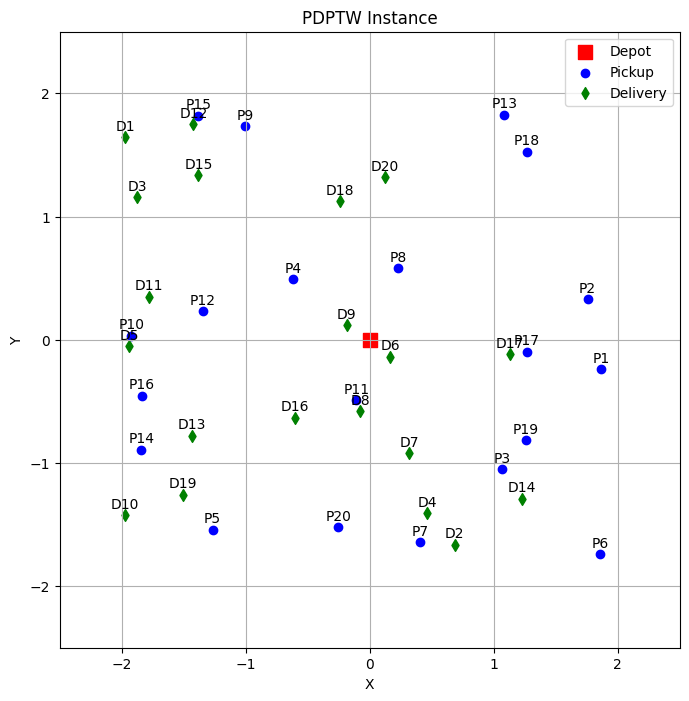

In [14]:
import random
from copy import deepcopy
import numpy as np
from copy import deepcopy
from instance import PDPTWInstance
from solution import PDPTWSolution
from solver import greedy_insertion_init
import matplotlib.pyplot as plt

n = 20
map_size = 2  
speed = 4 
extra_time = 10 
num_vehicles = 5
vehicle_capacity = 6 
battery_capacity = 255  
battery_consume_rate = 1
penalty = 5
gamma = 100

instance = PDPTWInstance(n, map_size, speed, extra_time, gamma, seed=1234)
instance.plot_instance()

Initial solution objective value 99.5594764521628
Unvisited pairs []
Unvisited pairs set()


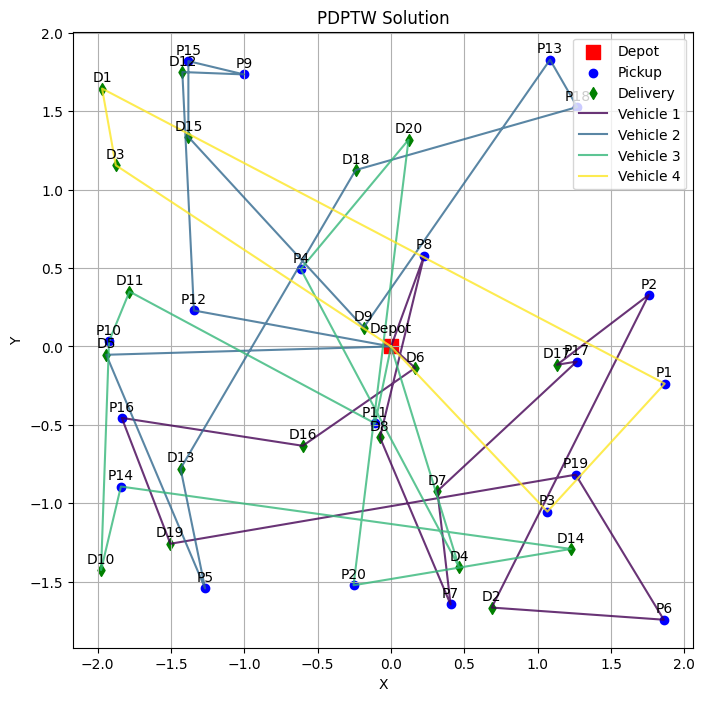

In [15]:
initial_solution = greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate, penalty)
print("Initial solution objective value", initial_solution.objective_function())
print("Unvisited pairs", initial_solution.unvisited_pairs)
print("Unvisited pairs", initial_solution.unvisited_requests)
initial_solution.plot_solution()

In [16]:
df = instance.to_dataframe()

# Reference matrix for SISR removal
df_orders = df.iloc[1:, :]
stops = df_orders[['X', 'Y']].values
e_times = df_orders[['ReadyTime']].values
l_times = df_orders[['DueDate']].values

def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

d_matrix = []
for i in range(n):
    d_list = []
    for j in range(n):
        d_1 = euclidean_distance(stops[i], stops[j])  # pickup-pickup
        t_1 = abs(e_times[i] - e_times[j]) / 60 * speed
        dt_1 = d_1 + t_1 * 0.1

        d_2 = euclidean_distance(stops[i], stops[j + n])  # pickup-dropoff
        t_2 = abs(e_times[i] - l_times[j + n]) / 60 * speed
        dt_2 = d_2 + t_2 * 0.1

        d_3 = euclidean_distance(stops[i + n], stops[j])  # dropoff-pickup
        t_3 = abs(e_times[j] - l_times[i + n]) / 60 * speed
        dt_3 = d_3 + t_3 * 0.1

        d_4 = euclidean_distance(stops[i + n], stops[j + n])  # dropoff-dropoff
        t_4 = abs(e_times[j + n] - l_times[i + n]) / 60 * speed
        dt_4 = d_4 + t_4 * 0.1

        d_min = min(dt_1, dt_2, dt_3, dt_4)[0]
        d_list.append(d_min)
    d_matrix.append(d_list)

In [17]:
len(instance.calculate_distance_matrix())

42

In [18]:
# 设置ALNS参数
params_operators = {
    'num_removal': 5,
    'p': 3,
    'k': 3,
    'L_max': 10,
    'avg_remove_order': 10
}
max_no_improve = 25
segment_length = 25
num_segments = 50
r = 0.2 # update the weights
sigma = [10, 5, 1]
start_temp = 100
cooling_rate = 0.99
dist_matrix = instance.calculate_distance_matrix()
battery = 10

# 创建ALNS实例
alns = ALNS(
    initial_solution=initial_solution,
    params_operators=params_operators,
    d_matrix=d_matrix,
    dist_matrix = dist_matrix,
    battery = battery,
    max_no_improve=max_no_improve,
    segment_length=segment_length,
    num_segments=num_segments,
    r=r,
    sigma=sigma,
    start_temp=start_temp,
    cooling_rate=cooling_rate
)
# uncharged_solution, charged_solution = alns.run(1)

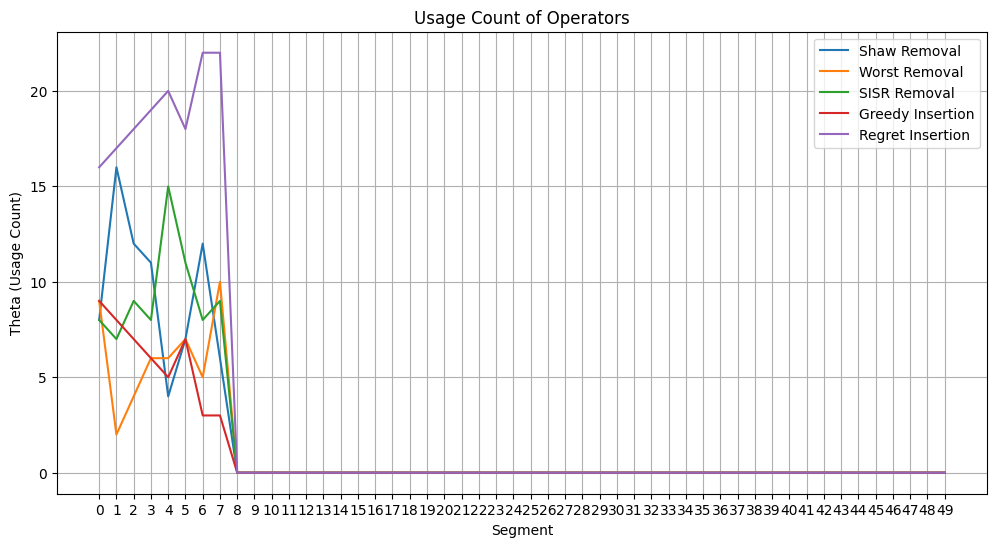

In [11]:
alns.plot_theta()

In [25]:
pip install --upgrade joblib

   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/301.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 301.8/301.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2
Note: you may need to restart the kernel to use updated packages.


In [19]:
from joblib import Parallel, delayed
import time
start_time = time.time()
# Execute the function in parallel
p = 7
start_s = 1
uncharge_result_list = []
charge_result_list = []

results = Parallel(n_jobs=p, return_as="generator_unordered")(delayed(alns.run)(i) for i in range(start_s, start_s + p))
for i in range(p):
    a = next(results)
    uncharge_result_list.append(a[0])
    obj_1 = a[0].objective_function()
    charge_result_list.append(a[1])
    obj_2 = a[1].objective_function()
    print(obj_1, obj_2)
    print("--- %s seconds ---" % (time.time() - start_time))

65.3050760812475 74.1020624925868
--- 165.8283429145813 seconds ---
58.23440259103779 74.36950526229973
--- 184.27093815803528 seconds ---
58.2344025910378 72.28663104448765
--- 228.03350687026978 seconds ---
58.23440259103779 73.41495039946074
--- 235.98926210403442 seconds ---
58.23440259103779 73.41495039946074
--- 297.7910592556 seconds ---
59.043940869184524 71.171651100238
--- 389.6878271102905 seconds ---
58.2344025910378 71.15975115905353
--- 482.1651165485382 seconds ---


charged_solution's objective value: 71.15975115905353
Routes [[0, 12, 9, 15, 32, 35, 29, 41, 2, 22, 0], [0, 20, 41, 18, 40, 38, 16, 36, 0], [0, 11, 5, 31, 10, 25, 14, 30, 41, 34, 0], [0, 3, 6, 19, 1, 17, 37, 26, 41, 39, 23, 21, 0], [0, 8, 4, 28, 7, 24, 27, 13, 41, 33, 0]]


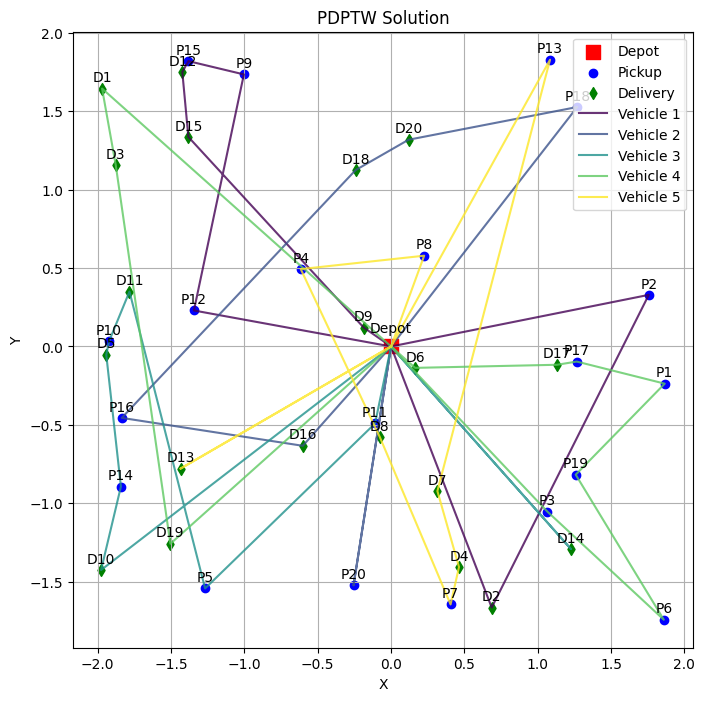

In [24]:
print("charged_solution's objective value:", charge_result_list[6].objective_function())
print("Routes", charge_result_list[6].routes)
charge_result_list[6].plot_solution()

# Test framework

In [62]:
import numpy as np
import matplotlib.pyplot as plt

class RealMap:
    def __init__(self, n_r, n_c):
        self.n_r = n_r  # Number of Restaurants
        self.n_c = n_c  # Number of Customers
        self.n = self.n_r + self.n_c  # Total number of nodes
        self.all_nodes = [0] + list(range(1, self.n + 1)) + [self.n + 1, self.n + 2]
        self.node_names = self.generate_node_dict()  # Save the name-to-index mapping

    def generate_coordinates(self, dist_function, dist_params)-> dict:
        '''
        Generate the random coordinates.
        :param dist_function: random function
        :param dist_params: corresponding parameters
        '''
        # Dynamically adjust the range based on the number of nodes
        range_multiplier = np.sqrt(1)
        self.coordinates = {}

        # Generate coordinates for pickup and delivery nodes
        for node in self.all_nodes[:self.n + 1]:
            x = dist_function(**dist_params) * range_multiplier
            y = dist_function(**dist_params) * range_multiplier
            self.coordinates[node] = (x, y)

        # Depot, destination, and charging station are placed at the same location
        self.coordinates[self.all_nodes[self.n + 1]] = self.coordinates[0]
        self.coordinates[self.all_nodes[self.n + 2]] = self.coordinates[0]

        return self.coordinates

    def generate_node_dict(self):
        ''' Generate a dictionary mapping node names to their indices. '''
        node_names = {}
        node_names[0] = 'depot'
        node_names[self.n + 1] = 'destination'
        node_names[self.n + 2] = 'charging_station'
        for i in range(1, self.n_r + 1):
            node_names[i] = f'r_{i}'
        for j in range(self.n_r + 1, self.n + 1):
            node_names[j] = f'c_{j - self.n_r}'
        return node_names

    def generate_pairs(self):
        ''' Generate all restaurant-customer pairs. '''
        pairs = []
        for r in range(1, self.n_r + 1):
            for c in range(self.n_r + 1, self.n + 1):
                pairs.append((r,c))
        return pairs

    def generate_time_matrix(self) -> np.ndarray:
        """
        Calculate the time matrix based on Euclidean distance between nodes.
        """
        num_nodes = len(self.all_nodes)
        self.time_matrix = np.zeros((num_nodes, num_nodes))

        for i in self.all_nodes:
            for j in self.all_nodes:
                if i != j:
                    dist = np.sqrt((self.coordinates[i][0] - self.coordinates[j][0])**2 +
                                   (self.coordinates[i][1] - self.coordinates[j][1])**2)
                    self.time_matrix[i][j] = dist
                    self.time_matrix[j][i] = dist  # Ensure the matrix is symmetric
                else:
                    self.time_matrix[i][j] = 0  # Distance to self is zero

        return self.time_matrix

    def plot_map(self, show_index=None):
        '''
        Plot all nodes on a map, optionally showing indices or names.
        '''
        fig, ax = plt.subplots()
        # Plotting nodes with different styles
        for node, (x, y) in self.coordinates.items():
            if node == 0 or node == self.n + 1 or node == self.n + 2:  # Special nodes
                ax.plot(x, y, 'o', markersize=10, markerfacecolor='none', markeredgecolor='black', label=self.node_names[node] if self.node_names[node] not in ax.get_legend_handles_labels()[1] else "")
            elif node <= self.n_r:  # Restaurants
                ax.plot(x, y, 's', color='red', label='Restaurant' if 'Restaurant' not in ax.get_legend_handles_labels()[1] else "")
            else:  # Customers
                ax.plot(x, y, '^', color='blue', label='Customer' if 'Customer' not in ax.get_legend_handles_labels()[1] else "")
            if show_index:
                label = node if show_index == 'number' else self.node_names[node]
                ax.text(x + 0.05, y + 0.05, f'{label}', fontsize=8, ha='right')  # Adjusted label position for clarity
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        # ax.legend()
        plt.show()


import numpy as np
import pandas as pd

def generate_demand_table(pairs, time_intervals, sample_dist, sample_params, demand_dist, demand_params) -> pd.DataFrame:
    """
    Generate the demand table with additional columns for pickup and delivery points.
    :param pairs: list of (pickup, delivery) tuples.
    :param time_intervals: list of time interval tuples.
    :param sample_dist: function to sample number of demands.
    :param sample_params: parameters for the sampling distribution function.
    :param demand_dist: function to generate demand values.
    :param demand_params: parameters for the demand distribution function.
    :return: Pandas DataFrame representing the demand table with additional columns for pickup and delivery.
    """
    # Initialize demand dictionary
    demand_dict = {pair: [0] * len(time_intervals) for pair in pairs}

    # Traverse each time interval and generate demands
    for idx, _ in enumerate(time_intervals):
        num_samples = sample_dist(**sample_params)
        sampled_pairs = np.random.choice(len(pairs), size=num_samples, replace=False)

        # Generate order quantity for each sampled pair
        for sample in sampled_pairs:
            pair = pairs[sample]
            order_quantity = -1
            # Ensure order_quantity is not 0
            while order_quantity < 0:
                order_quantity = demand_dist(**demand_params)
            demand_dict[pair][idx] += order_quantity

    # Convert the dictionary to Pandas DataFrame
    demand_table = pd.DataFrame(demand_dict, index=[f"{start}-{end}" for start, end in time_intervals])
    # Transpose DataFrame, so each row represents a pair and each column represents a time interval
    demand_table = demand_table.T

    # Add columns for pickup and delivery points
    demand_table['Pickup'] = [pair[0] for pair in pairs]
    demand_table['Delivery'] = [pair[1] for pair in pairs]

    # Rearrange columns to move Pickup and Delivery to the front
    cols = ['Pickup', 'Delivery'] + [col for col in demand_table.columns if col not in ['Pickup', 'Delivery']]
    demand_table = demand_table[cols]

    # Reset index to start from 1
    demand_table.reset_index(drop=True, inplace=True)
    demand_table.index += 1

    return demand_table

def generate_order_details(demand_table, locations):
    """
    Generate a detailed DataFrame for each order based on the demand table and location coordinates.

    :param demand_table: DataFrame with demand information per time interval.
    :param locations: Dictionary with coordinates for each restaurant and customer.
    :return: DataFrame with detailed order information including real indices.
    """
    n = demand_table.iloc[:, 2:].sum().sum() # Total number of the orders
    arrive_time_list = []
    x_list = []
    y_list = []
    count = 0
    real_index_list = []
    order_pair_index_list = []

    # Iterate over each time interval column in demand_table
    for j in range(2, demand_table.shape[1]):  # Assuming the first two columns are 'Pickup' and 'Delivery'
        time_start = int(demand_table.columns[j].split('-')[0])  # Extract start of the time interval
        # Iterate over each order pair
        for i in range(demand_table.shape[0]):
            orders_count = demand_table.iloc[i, j]
            if orders_count > 0:
                # Generate order details for each order
                for _ in range(orders_count):
                    count += 1
                    pickup_label = demand_table.iloc[i, 0]
                    delivery_label = demand_table.iloc[i, 1]

                    # Restaurant information
                    order_pair_index_list.append(count)
                    x_list.append(locations[pickup_label][0])
                    y_list.append(locations[pickup_label][1])
                    arrive_time_list.append(time_start)
                    real_index_list.append(pickup_label)

                    # Customer information
                    order_pair_index_list.append(count + n)
                    x_list.append(locations[delivery_label][0])
                    y_list.append(locations[delivery_label][1])
                    arrive_time_list.append(time_start + 10)  # Assuming some fixed travel or processing time
                    real_index_list.append(delivery_label)

    df_point = pd.DataFrame({
        "pair_index": order_pair_index_list,
        "x": x_list,
        "y": y_list,
        "earliest": arrive_time_list,
        "real_index": real_index_list
    })

    return df_point


In [75]:
if __name__ == "__main__":

    # Generate location
    real_map = RealMap(n_r=27, n_c=131)
    # coordinates = real_map.generate_coordinates(np.random.uniform, {'low': -1.5, 'high': 1.5})
    # Current used experiment locations
    # coordinates = {0: (0, 0),
    #     1: (1.292868646, -0.302045883),
    #     2: (-0.056930352, -0.962152098),
    #     3: (-0.746257601, 0.099703316),
    #     4: (0.760611739, 0.798790627),
    #     5: (0.203613294, -0.658268145),
    #     6: (0.988120267, 1.345657551),
    #     7: (0.56121126, 1.216901494),
    #     8: (1.401092048, 0.228185941),
    #     9: (-1.052577951, -1.054442319),
    #     10: (0.880369055, -0.807016107),
    #     11: (-0.049018012, -0.162877981),
    #     12: (1.013596099, -0.31572833),
    #     13: (-0.276510811, -0.414252885),
    #     14: (-0.562945145, -0.036814328),
    #     15: (-0.503990048, 0.718230584),
    #     16: (0.861490183, 1.411387901),
    #     17: (-0.493466574, -0.651987251),
    #     18: (-0.271741709, 1.092600522),
    #     19: (1.453935495, 0.674118634),
    #     20: (1.372217256, 0.24965499)
    # }
    real_map = RealMap(n_r=27, n_c=131)
    df = pd.read_csv('purdue_node_info.csv')
    coordinates = {i + 1: (row['longitude'], row['latitude']) for i, row in df.iterrows()}
    coordinates[0] = (-86.911391, 40.4249552)

In [94]:
# Generate scenarios
def scenario_generation(average_order):
  pairs = real_map.generate_pairs()
  time_intervals = ((0, 15),(15, 30),(30, 45),(45, 60),(60, 75),(75, 90),(90, 105),(105, 120))
  csv_filenames = []
  demand_table = generate_demand_table(
      pairs, time_intervals,
      sample_dist=np.random.randint, sample_params={'low': 27*131-0.5, 'high': 27*131}, # Select all pairs
      demand_dist=np.random.poisson, demand_params={'lam': average_order/(27*131)/8}) # in 8 time steps, generate 0.5*100 = 50 orders on average
  order_pairs_table = generate_order_details(demand_table, coordinates)
  # print(demand_table.iloc[:, 2:].sum().sum())

  # prompt: Generate latest time, if pair index is equal to or smaller than n/2, latest time is 'inf', otherwise it earliest + 60
  latest_time = [np.inf if order_pairs_table.loc[i,'pair_index'] <= len(order_pairs_table)/2 else order_pairs_table.loc[i,'earliest'] + 60 for i in range(len(order_pairs_table))]
  order_pairs_table['latest'] = latest_time
  demand = [1 if order_pairs_table.loc[i,'pair_index'] <= len(order_pairs_table)/2 else -1 for i in range(len(order_pairs_table))]
  order_pairs_table['demand'] = demand
  order_pairs_table['ServiceTime'] = 2
  # order_pairs_table = order_pairs_table.drop(columns=['real_index'])
  columns = ['ID', 'X', 'Y', 'ReadyTime','real_index','DueDate', 'Demand', 'ServiceTime']
  order_pairs_table.columns = columns

  d_first = []
  d_first.append([int(0),-86.911391,40.4249552,0,17,float('inf'),0,0]) #depot is at node 17
  d_first = pd.DataFrame(d_first, columns=columns)
  order_pairs_table = pd.concat([d_first,order_pairs_table], axis = 0) #depot is at node 17
  d_last = []
  d_last.append([int(max(order_pairs_table.ID)+1),-86.911391,40.4249552,0,17,float('inf'),0,2])
  d_last = pd.DataFrame(d_last, columns=columns)
  order_pairs_table = pd.concat([order_pairs_table,d_last], axis = 0)
  order_pairs_table.sort_values(by=['ID'], inplace=True)
  order_pairs_table.reset_index(drop=True, inplace=True)

  tt_matrix = pd.read_csv('tt_matrix.csv', header = None)
  dist_matrix = []
  for i in range(len(order_pairs_table)):
    dist_list = []
    for j in range(len(order_pairs_table)):
      dist_list.append((tt_matrix.loc[order_pairs_table.loc[i,'real_index']-1, order_pairs_table.loc[j,'real_index']-1])/1000)
    dist_matrix.append(dist_list)
  dist_matrix = np.array(dist_matrix)
  #   order_pairs_table.to_csv(f'Instance_{i}.csv')
  #   csv_filenames.append(f'Instance_{i}.csv')
    
  #   # Zip the CSV files
  #   zip_filename = 'dataframes.zip'
  #   with zipfile.ZipFile(zip_filename, 'w') as zipf:
  #       for csv_filename in csv_filenames:
  #           zipf.write(csv_filename)
  return order_pairs_table, dist_matrix

In [81]:
df, dist_matrix = scenario_generation(10)

In [84]:
df

,ID,X,Y,ReadyTime,real_index,DueDate,Demand,ServiceTime
0,0,-86.911391,40.424955,0,17,inf,0,0
1,1,-86.907081,40.424333,0,9,inf,1,2
2,2,-86.911381,40.425274,0,13,inf,1,2
3,3,-86.907894,40.425904,15,21,inf,1,2
4,4,-86.907781,40.422852,30,22,inf,1,2
5,5,-86.907678,40.422761,45,4,inf,1,2
6,6,-86.911175,40.425386,45,16,inf,1,2
7,7,-86.911175,40.425386,45,16,inf,1,2
8,8,-86.911462,40.424930,45,19,inf,1,2
9,9,-86.911175,40.425386,60,16,inf,1,2


In [105]:
import random
from copy import deepcopy
import numpy as np
from copy import deepcopy
from instance import PDPTWInstance
from solution import PDPTWSolution
from solver import greedy_insertion_init
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import time
import glob

def update_instance(instance, df, dist_matrix):
    instance.n = int((df.shape[0] - 2)/2)
    n = instance.n
    instance.depot = (df.X[0], df.Y[0])  # depot 位于原点
    instance.pickup_points = [(df.X[i], df.Y[i]) for i in range(1, n+1)]
    instance.delivery_points = [(df.X[i], df.Y[i]) for i in range(n+1, 2*n+1)] # delivery 点的坐标
    instance.charging = (df.X[2*n+1], df.Y[2*n+1])
    instance.indices = list(df.ID)
    instance.time_windows = [(df.ReadyTime[i], df.DueDate[i]) for i in df.index]
    instance.service_times = list(df.ServiceTime)
    instance.demands = list(df.Demand)
    # instance.distance_matrix = instance.calculate_distance_matrix() # 距离矩阵
    instance.distance_matrix = dist_matrix
    instance.time_matrix = instance.calculate_time_matrix()

n = 13
map_size = 2  
speed = 4 
extra_time = 0 
num_vehicles = 14
vehicle_capacity = 6 
# battery_capacity = 255  
battery_consume_rate = 1
penalty = 15
gamma = 100

result_list = []
penalty_list = []

#initialize instance, will be updated
instance = PDPTWInstance(n, map_size, speed, extra_time, gamma)

average_order = 70

def battery_relaxation(i):
    if i == 1:
        battery_capacity = (battery - np.mean(dist_matrix[0][1:-1]))*2/speed*60
    else:
        battery_capacity = battery/speed*60
    return battery_capacity

for i in range(20):
# for seed_x in seed_list:
    battery_relax = 0
    start_time = time.time()
    df, dist_matrix = scenario_generation(average_order)
    # print("instance: ",file_list[i])
    # df = pd.read_csv(file_list[i])
    # instance = PDPTWInstance(n, map_size, speed, extra_time, gamma, seed=seed_x)
    # instance = PDPTWInstance(n, map_size, speed, extra_time, gamma)
    update_instance(instance, df, dist_matrix)

    df = instance.to_dataframe()
    n = instance.n
    print(n)

    # Reference matrix for SISR removal
    df_orders = df.iloc[1:, :]
    stops = df_orders[['X', 'Y']].values
    e_times = df_orders[['ReadyTime']].values
    l_times = df_orders[['DueDate']].values

    # def euclidean_distance(p1, p2):
    #     return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    d_matrix = []
    for i in range(n):
        d_list = []
        for j in range(n):
            # d_1 = euclidean_distance(stops[i], stops[j])  # pickup-pickup
            d_1 = dist_matrix[i+1, j+1]
            t_1 = abs(e_times[i] - e_times[j]) / 60 * speed
            dt_1 = d_1 + t_1 * 0.3

            # d_2 = euclidean_distance(stops[i], stops[j + n])  # pickup-dropoff
            d_2 = dist_matrix[i+1, j + n +1]
            t_2 = abs(e_times[i] - l_times[j + n]) / 60 * speed
            dt_2 = d_2 + t_2 * 0.3

            # d_3 = euclidean_distance(stops[i + n], stops[j])  # dropoff-pickup
            d_3 = dist_matrix[i + 1 + n, j + 1]
            t_3 = abs(e_times[j] - l_times[i + n]) / 60 * speed
            dt_3 = d_3 + t_3 * 0.3

            # d_4 = euclidean_distance(stops[i + n], stops[j + n])  # dropoff-dropoff
            d_4 = dist_matrix[i + 1 + n, j + n + 1]
            t_4 = abs(e_times[j + n] - l_times[i + n]) / 60 * speed
            dt_4 = d_4 + t_4 * 0.3

            d_min = min(dt_1, dt_2, dt_3, dt_4)[0]
            d_list.append(d_min)
        d_matrix.append(d_list)

    # 设置ALNS参数
    n_remove = int(n*0.3)
    params_operators = {
        'num_removal': n_remove,
        'p': 3,
        'k': 3,
        'L_max': 6,
        'avg_remove_order': 6
    }
    max_no_improve = 25
    segment_length = 25
    num_segments = 20
    r = 0.2 # update the weights
    sigma = [10, 5, 1]
    start_temp = 100
    cooling_rate = 0.99
    # dist_matrix = instance.calculate_distance_matrix()
    battery = 10

    battery_capacity = battery_relaxation(battery_relax)
    
    if battery_capacity>(battery/speed*60):
        print('Relaxed', num_vehicles)
    else:
        print("PDPTW", num_vehicles)
        
    penalty_list.append(penalty)
    initial_solution = greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate, penalty)

    # 创建ALNS实例
    alns = ALNS(
        initial_solution=initial_solution,
        params_operators=params_operators,
        d_matrix=d_matrix,
        dist_matrix = dist_matrix,
        battery = battery,
        max_no_improve=max_no_improve,
        segment_length=segment_length,
        num_segments=num_segments,
        r=r,
        sigma=sigma,
        start_temp=start_temp,
        cooling_rate=cooling_rate
    )

    start_time = time.time()
    # Execute the function in parallel
    p = 3
    start_s = 1
    uncharge_result_list = []
    charge_result_list = []
    uncharge_obj_list = []
    charge_obj_list = []

    results = Parallel(n_jobs=p, return_as="generator_unordered")(delayed(alns.run)(i) for i in range(start_s, start_s + p))
    for i in range(p):
        a = next(results)
        uncharge_result_list.append(a[0])
        obj_1 = a[0].objective_function()
        uncharge_obj_list.append(obj_1)
        charge_result_list.append(a[1])
        obj_2 = a[1].objective_function()
        charge_obj_list.append(obj_2)
        # print(obj_1, obj_2)
        # print("--- %s seconds ---" % (time.time() - start_time))
    
    min_value = min(uncharge_obj_list)
    min_index = uncharge_obj_list.index(min_value)
    min_uncharge = uncharge_result_list[min_index]

    min_value = min(charge_obj_list)
    min_index = charge_obj_list.index(min_value)
    min_charge = charge_result_list[min_index]
    result_list.append([min_uncharge, min_charge])
    print("--- %s seconds ---" % (time.time() - start_time))


73
PDPTW 14


In [103]:
df

,ID,Type,X,Y,Demand,ReadyTime,DueDate,ServiceTime,PartnerID
0,0,d,-86.911391,40.424955,0,0,inf,0,0
1,1,cp,-86.906778,40.424065,1,0,inf,2,11
2,2,cp,-86.911372,40.425383,1,0,inf,2,12
3,3,cp,-86.907894,40.425904,1,30,inf,2,13
4,4,cp,-86.907766,40.424565,1,30,inf,2,14
5,5,cp,-86.911372,40.425383,1,45,inf,2,15
6,6,cp,-86.907781,40.422852,1,45,inf,2,16
7,7,cp,-86.907781,40.422852,1,60,inf,2,17
8,8,cp,-86.906861,40.422990,1,60,inf,2,18
9,9,cp,-86.907781,40.422852,1,75,inf,2,19


In [104]:
d_matrix

[[0.0,
  0.527552,
  0.3473636666666667,
  0.339012,
  0.5364446666666667,
  0.5155120000000001,
  0.5699386666666666,
  0.48150766666666667,
  0.5366053333333333,
  0.35913633333333334],
 [0.5329,
  0.0,
  0.38702666666666663,
  0.5474706666666667,
  0.30000000000000004,
  0.7334236666666667,
  0.6334236666666666,
  0.5382706666666667,
  0.6000903333333333,
  0.41413733333333336],
 [0.3596236666666667,
  0.38702666666666663,
  0.0,
  0.16044399999999998,
  0.478529,
  0.55017,
  0.5177686666666667,
  0.38297366666666666,
  0.4177686666666667,
  0.35355466666666663],
 [0.339012,
  0.5474706666666667,
  0.16044399999999998,
  0.0,
  0.619129,
  0.389726,
  0.489726,
  0.39080000000000004,
  0.5336190000000001,
  0.4],
 [0.5364446666666667,
  0.30000000000000004,
  0.478529,
  0.619129,
  0.0,
  0.640251,
  0.740251,
  0.736722,
  0.7802100000000001,
  0.8191290000000001],
 [0.5155120000000001,
  0.7334236666666667,
  0.549762,
  0.38931799999999994,
  0.640251,
  0.0,
  0.1,
  0.234795,

In [72]:
dist_list = []
dist_uncharge_list = []
max_dist_list = []
obj_list = []
obj_uncharge_list = []
veh_list = []
count_battery_swapping = []
order_count = []

for i in result_list:
    bs_count = 0
    order_count.append(i[0].instance.n)
    dist_uncharge_list.append(np.sum(i[0].total_travel_times)/60*speed)
    dist_list.append(np.sum(i[1].total_travel_times)/60*speed)
    max_dist_list.append(max(i[0].total_travel_times)/60*speed)
    obj_uncharge_list.append(i[0].objective_function())
    obj_list.append(i[1].objective_function())
    veh_list.append(len([sublist for sublist in i[0].routes if sublist!=[0,0]]))
    for route in i[1].routes:
        if 2*(i[1].instance.n)+1 in route:
            bs_count += 1
    count_battery_swapping.append(bs_count)


In [73]:
df = pd.DataFrame({"order": order_count,"penalty": penalty_list[:], "distance_uncharge": dist_uncharge_list, "obj_uncharge": obj_uncharge_list, "max_dist": max_dist_list,"distance_charge": dist_list, "obj_charge": obj_list, "num_veh": veh_list, "battery_swapping": count_battery_swapping})
df

,order,penalty,distance_uncharge,obj_uncharge,max_dist,distance_charge,obj_charge,num_veh,battery_swapping
0,32,15,40.675428,145.675428,11.710502,41.454417,146.454417,4,3
1,28,15,37.490810,82.490810,10.762607,37.512060,82.512060,4,1
2,40,15,46.519135,196.519135,16.404334,46.537761,196.537761,4,2
3,30,15,41.476154,101.476154,12.936185,41.735652,101.735652,4,2
4,24,15,32.069892,77.069892,11.431753,32.303490,77.303490,4,1
5,27,15,39.119213,99.119213,12.930245,39.259501,99.259501,4,1
6,30,15,37.593301,97.593301,10.995543,37.593686,97.593686,4,1
7,30,15,37.325081,82.325081,11.458260,38.519489,83.519489,4,2
8,35,15,43.000592,148.000592,17.217973,44.658622,164.658622,4,2
9,27,15,40.513485,70.513485,10.884006,42.139390,72.139390,4,3
